In [1]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, LambdaCallback
from keras.callbacks import EarlyStopping, TensorBoard
import argparse
import midi
import os

from constants import *
from dataset import load_all
from generate import write_file, generate
from play_music_util import play_music

import pygame
import base64

from playsound import playsound

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np
import tensorflow as tf
from keras.layers import Input, LSTM, Dense, Dropout, Lambda, Reshape, Permute
from keras.layers import TimeDistributed, RepeatVector, Conv1D, Activation
from keras.layers import Embedding, Flatten, dot, concatenate 
from keras.layers.merge import Concatenate, Add, Multiply
from keras.models import Model
import keras.backend as K
from keras import losses
from keras.utils import multi_gpu_model

In [3]:
styles[0]

['data/test']

In [4]:
print('Loading data')
train_data, train_labels = load_all(styles, BATCH_SIZE, SEQ_LEN)

Loading data


In [5]:
train_data[0].shape

(10, 128, 48, 3)

In [5]:
for i in range(3):
    print(train_data[i].shape)

(10, 128, 48, 3)
(10, 128, 48, 3)
(10, 128, 16)


In [25]:
# train_labels[0].shape

In [6]:
from model import *

In [7]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [8]:
 BATCH_SIZE, NUM_NOTES, NOTE_UNITS

(32, 48, 3)

In [73]:
cuda = False

def iterate_minibatches(train_data, train_labels, batchsize):
    indices = np.random.permutation(np.arange(len(train_labels)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        
        if cuda:      
            yield  Variable(torch.FloatTensor(train_data[ix])).cuda(), Variable(torch.FloatTensor(train_labels[ix])).cuda()
        else:
            yield Variable(torch.FloatTensor(train_data[ix])), Variable(torch.FloatTensor(train_labels[ix]))

#  Pytorch implementation

In [75]:
class time_axis(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__() 
        self.n_layers = 1
        self.hidden_size = TIME_AXIS_UNITS
        self.input_size = NOTE_UNITS
        

        self.time_lstm = nn.LSTM(self.input_size, self.hidden_size, self.n_layers, dropout=0.1, 
                                 batch_first=True, )
        self.dropout = nn.Dropout(p=0.2, inplace=True)
        
    def forward(self, notes):
        
        """
        arg:
            notes - (batch, time_seq, note_seq, note_features)
        
        out: 
            (batch, time_seq, note_seq, hidden_features)
            
        """
        
        lstm_out = []
#         i_hidden = self.init_hidden()
        
#         print('notes.shape[2] : ', notes.shape[2])
        
        for i in range(notes.shape[2]):
            
            out, hidden = self.time_lstm(notes[:, :, i,:]) 
            
#             print('out', out.shape)
            
            lstm_out.append(out[:, :, None, :])
            
#             print('out2', out[:, :, None, :].shape)
        
        
        time_output = torch.cat(lstm_out, dim=2)
#         self.dropout(time_output)
#         print('time_output', time_output.shape)
        
        return time_output        
    


In [12]:
# dummy_note = Variable(torch.Tensor(train_data[0]).view(train_data[0].shape[:-2]
#                       +(train_data[0].shape[-2]*train_data[0].shape[-1],)))
# dummy_note.shape

In [13]:
# train_data[0].shape[:-1]+(train_data[0].shape[-2]*train_data[0].shape[-1], )

In [143]:
dummy_note = Variable(torch.Tensor(train_data[0]))
print('dummy_note: ', dummy_note.shape)
ta = time_axis()

# dummy_time_features = ta.forward(dummy_note)
dummy_time_features = generator.time_ax(dummy_note)

print('dummy_time_features :', dummy_time_features.shape)

dummy_note:  torch.Size([10, 128, 48, 3])
dummy_time_features : torch.Size([10, 128, 48, 256])


In [15]:
dummy_time_features.shape

torch.Size([10, 128, 48, 256])

In [108]:
class note_axis(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()   
        
        self.n_layers = 2
        self.hidden_size = NOTE_AXIS_UNITS
        # number of time features plus number of previous higher note in the same time momemt
        self.input_size = TIME_AXIS_UNITS + NOTE_UNITS
        
        # maybe it is better to make two lstm and make the second one bideractional 
        self.note_lstm = nn.LSTM(self.input_size, self.hidden_size, self.n_layers, dropout=0.1, 
                                 batch_first=True, )
        
        self.dropout = nn.Dropout(p=0.2, inplace=True)
        
        self.logits = nn.Linear(self.hidden_size, NOTE_UNITS) 
        
    def forward(self, notes, chosen):
        """
        arg:
            notes - (batch, time_seq, note_seq, time_hidden_features)
        
        out: 
            (batch, time_seq, note_seq, next_notes_features)
            
        """
                
        # Shift target one note to the left.
        shift_chosen = nn.ZeroPad2d((0, 0, 1, 0))(chosen[:, :, :-1, :])
#         print('shift_chosen: ', shift_chosen.shape)
        
#         print('notes: ', notes.shape)
              
        note_input = torch.cat([notes, shift_chosen], dim=-1)
        
#         print('notes.shape[2] : ', note_input.shape)
        
        lstm_out = []
        for i in range(notes.shape[1]):
            
            out, hidden = self.note_lstm(note_input[:, i, :,:]) 
            
#             print('out', out.shape)
            
            lstm_out.append(out[:, None, :, :])
        
        
        time_output = torch.cat(lstm_out, dim=1)
#         self.dropout(time_output)

        logits = self.logits(time_output) 
        next_notes = nn.Sigmoid()(logits)
            
#         print('logits', logits.shape)
        
        return next_notes   

In [109]:
chosen = Variable(torch.Tensor(train_data[1]))
na = note_axis()

next_notes_features = na.forward(dummy_time_features, chosen)

print('dummy_time_features :', next_notes_features.shape)

dummy_time_features : torch.Size([10, 128, 48, 3])


In [110]:
class Generator(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()        
        
        self.time_ax = time_axis() 
        self.note_ax = note_axis()
        
    def forward(self, notes, chosen):
        
        note_ax_output = self.time_ax(notes)
        output = self.note_ax(note_ax_output, chosen)
        
        return output        

In [154]:
dummy_note = Variable(torch.Tensor(train_data[0]))
chosen = Variable(torch.Tensor(train_data[1]))

generator = Generator()

output = generator.forward(dummy_note, chosen)
output2 = the_model.forward(dummy_note, chosen)

print('dummy_time_features :', output.shape)

dummy_time_features : torch.Size([10, 128, 48, 3])


In [159]:
output[0][0]

Variable containing:
 0.4928  0.5027  0.4898
 0.4950  0.5018  0.4917
 0.4965  0.5014  0.4923
 0.4968  0.5007  0.4928
 0.4972  0.5009  0.4931
 0.4974  0.5009  0.4931
 0.4973  0.5007  0.4928
 0.4972  0.5008  0.4934
 0.4971  0.5015  0.4931
 0.4976  0.5012  0.4931
 0.4974  0.5008  0.4934
 0.4978  0.5012  0.4934
 0.4974  0.5010  0.4932
 0.4972  0.5005  0.4939
 0.4974  0.5008  0.4934
 0.4976  0.5010  0.4927
 0.4977  0.5004  0.4932
 0.4975  0.5005  0.4932
 0.4976  0.5004  0.4934
 0.4975  0.5001  0.4936
 0.4974  0.5005  0.4936
 0.4974  0.5005  0.4936
 0.4972  0.5007  0.4934
 0.4973  0.5013  0.4930
 0.4975  0.5010  0.4917
 0.4974  0.5008  0.4926
 0.4971  0.5010  0.4931
 0.4977  0.5006  0.4933
 0.4970  0.5008  0.4935
 0.4975  0.5013  0.4932
 0.4973  0.5013  0.4935
 0.4973  0.5012  0.4932
 0.4973  0.5011  0.4934
 0.4978  0.5010  0.4932
 0.4976  0.5008  0.4934
 0.4977  0.5007  0.4927
 0.4975  0.5008  0.4929
 0.4973  0.5011  0.4930
 0.4971  0.5013  0.4927
 0.4972  0.5010  0.4931
 0.4976  0.5008  0.

In [158]:
output2[0][0]

Variable containing:
 0.3952  0.4475  0.5165
 0.1897  0.3380  0.5307
 0.0645  0.2216  0.5541
 0.0294  0.1574  0.5696
 0.0199  0.1276  0.5845
 0.0182  0.1198  0.5884
 0.0164  0.1154  0.5859
 0.0161  0.1159  0.5842
 0.0156  0.1135  0.5924
 0.0157  0.1109  0.5817
 0.0157  0.1134  0.5926
 0.0165  0.1150  0.5898
 0.0158  0.1132  0.5845
 0.0155  0.1115  0.5887
 0.0153  0.1122  0.5867
 0.0159  0.1130  0.5819
 0.0162  0.1148  0.5842
 0.0153  0.1105  0.5879
 0.0152  0.1103  0.5922
 0.0154  0.1120  0.5872
 0.0157  0.1114  0.5854
 0.0152  0.1140  0.5871
 0.0155  0.1132  0.5825
 0.0156  0.1138  0.5892
 0.0160  0.1145  0.5870
 0.0157  0.1118  0.5878
 0.0162  0.1143  0.5914
 0.0162  0.1137  0.5816
 0.0153  0.1088  0.5875
 0.0152  0.1120  0.5855
 0.0155  0.1090  0.5874
 0.0158  0.1125  0.5847
 0.0150  0.1123  0.5828
 0.0153  0.1127  0.5879
 0.0152  0.1117  0.5911
 0.0154  0.1114  0.5870
 0.0150  0.1105  0.5849
 0.0157  0.1135  0.5856
 0.0156  0.1111  0.5941
 0.0156  0.1112  0.5871
 0.0149  0.1117  0.

In [103]:
# def primary_loss(y_true, y_pred):
#     # 3 separate loss calculations based on if note is played or not
#     played = y_true[:, :, :, 0]
#     bce_note = losses.binary_crossentropy(y_true[:, :, :, 0], y_pred[:, :, :, 0])
#     bce_replay = losses.binary_crossentropy(y_true[:, :, :, 1], tf.multiply(played, y_pred[:, :, :, 1]) + tf.multiply(1 - played, y_true[:, :, :, 1]))
#     mse = losses.mean_squared_error(y_true[:, :, :, 2], tf.multiply(played, y_pred[:, :, :, 2]) + tf.multiply(1 - played, y_true[:, :, :, 2]))
#     return bce_note + bce_replay + mse

In [111]:
criterion_bce_play = nn.BCELoss()  
criterion_bce_replay = nn.BCELoss() 
criterion_mse = nn.MSELoss()  

def compute_loss(y_pred, y_true):
    
    played = y_true[:, :, :, 0]
    
    bce_note = criterion_bce_play(y_pred[:, :, :, 0], y_true[:, :, :, 0])

    replay = played*y_pred[:, :, :, 1] + (1 - played)*y_true[:, :, :, 1]
    
    bce_replay = criterion_bce_replay(replay, y_true[:, :, :, 1])
    
    volume = played*y_pred[:, :, :, 2] + (1 - played)*y_true[:, :, :, 2]
    mse = criterion_mse(volume, y_true[:, :, :, 2] )
    
    return bce_note + bce_replay + mse


In [112]:
compute_loss(output, chosen)

Variable containing:
 0.7402
[torch.FloatTensor of size 1]

In [113]:
generator = Generator()

In [114]:
train_data[0].shape

(10, 128, 48, 3)

In [136]:
X_tr = train_data[0][:-1]
X_te = train_data[0][-1:]
y_tr = train_labels[0][:-1]
y_te = train_labels[0][-1:]

In [137]:
X_tr.shape, X_te.shape

((9, 128, 48, 3), (1, 128, 48, 3))

In [138]:
len(X_tr)

9

In [139]:
import math
import time
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

Epoch 3 of 3 took 73.395s
current train loss: 0.11898569266001384
current val loss: 0.20192551612854004


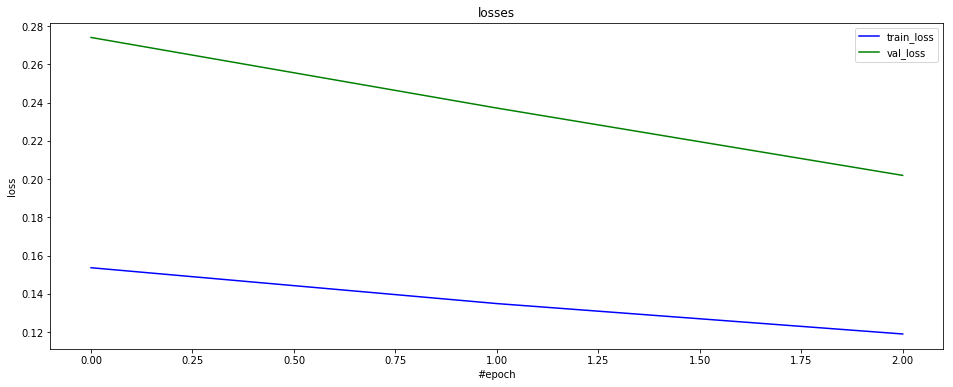

Finished!


In [140]:
from tqdm import tqdm
from torch import optim

n_epochs = 3
batchsize = 3
optimizer = optim.Adam(generator.parameters())
n_train_batches = math.ceil(len(X_tr)/batchsize)
n_validation_batches = math.ceil(len(X_te)/batchsize)

epoch_history = {'train_loss':[], 'val_loss':[]}

for epoch in range(n_epochs):
    
    start_time = time.time()
    
    train_loss = 0
    generator.train(True)    
    for X, y in tqdm(iterate_minibatches(X_tr, y_tr, batchsize)):
         
        optimizer.zero_grad()
                     
        pred = generator(X, y)
        loss = compute_loss(pred, y)        
        loss.backward()
                     
        optimizer.step()
        
        train_loss += loss.cpu().data.numpy()[0]
        
    train_loss /= n_train_batches
    epoch_history['train_loss'].append(train_loss)
#     print('train_loss', train_loss)
    
    generator.train(False)
    val_loss = 0
    for X, y in tqdm(iterate_minibatches(X_te, y_te, batchsize)):
        pred = generator(X, y)
        loss = compute_loss(pred, y) 

        val_loss += loss.cpu().data.numpy()[0]
           
    val_loss /= n_validation_batches
    epoch_history['val_loss'].append(val_loss)
#     print('val_loss', val_loss)
    
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(16, 6))
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, n_epochs, time.time() - start_time)) 
    print('current train loss: {}'.format(epoch_history['train_loss'][-1]))
    print('current val loss: {}'.format(epoch_history['val_loss'][-1]))
       
    plt.title("losses")
    plt.xlabel("#epoch")
    plt.ylabel("loss")
    plt.plot(epoch_history['train_loss'], 'b', label = 'train_loss')
    plt.plot(epoch_history['val_loss'], 'g', label = 'val_loss')
    plt.legend()
    plt.show()
    
print("Finished!")

In [142]:
generator.time_ax, generator.note_ax

(time_axis(
   (time_lstm): LSTM(3, 256, batch_first=True, dropout=0.1)
   (dropout): Dropout(p=0.2, inplace)
 ), note_axis(
   (note_lstm): LSTM(259, 128, num_layers=2, batch_first=True, dropout=0.1)
   (dropout): Dropout(p=0.2, inplace)
   (logits): Linear(in_features=128, out_features=3)
 ))

In [145]:
generator.train(False) 

Generator(
  (time_ax): time_axis(
    (time_lstm): LSTM(3, 256, batch_first=True, dropout=0.1)
    (dropout): Dropout(p=0.2, inplace)
  )
  (note_ax): note_axis(
    (note_lstm): LSTM(259, 128, num_layers=2, batch_first=True, dropout=0.1)
    (dropout): Dropout(p=0.2, inplace)
    (logits): Linear(in_features=128, out_features=3)
  )
)

In [151]:
torch.save(generator.state_dict(), os.path.join(OUT_DIR, 'model_canonical'))
the_model = Generator()
the_model.load_state_dict(torch.load(os.path.join(OUT_DIR, 'model_canonical')))

In [152]:
write_file('output/canonical_test', generate(the_model, 4))

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 4))



Generating with no styles:


TypeError: 'Generator' object is not iterable

# Canonical

In [21]:
MASK = False
self_attention = False
attention_in_note = False
models = build_models()

In [22]:
cbs = [
    ModelCheckpoint(os.path.join(OUT_DIR, 'model_canonical.h5'), monitor='loss', save_best_only=True, save_weights_only=True),
    EarlyStopping(monitor='loss', patience=5),
    #TensorBoard(log_dir='out/logs', histogram_freq=1)
]

print('Training')
models[0].fit(train_data, train_labels, validation_split=0.05,
              epochs=2, callbacks=cbs, batch_size=1)


Training
Train on 9 samples, validate on 1 samples
Epoch 1/2
9/9 [==============================] - 15s 2s/step - loss: 1.1476 - val_loss: 1.8936
Epoch 2/2
9/9 [==============================] - 11s 1s/step - loss: 0.9959 - val_loss: 1.8699


In [23]:
models = build_models()
models[0].load_weights(os.path.join(OUT_DIR, 'model_canonical.h5'))
write_file('output/canonical_test', generate(models, 4))

  0%|          | 0/64 [00:00<?, ?it/s]

Generating with no styles:


100%|██████████| 64/64 [00:55<00:00,  1.16it/s]

Writing file out/samples/output/canonical_test_0.mid


In [21]:
midi_file = 'out/samples/output/canonical_test_0.mid'
play_music(midi_file)

Music file out/samples/output/canonical_test_0.mid loaded!


# Testing keras function

In [9]:
fpath = os.path.join(SAMPLES_DIR, 'encode_decoded_song' + '_' + str(i) + '.mid')
pattern = midi.read_midifile('data/Bach1/Toccata & Fuga in F-Dur, BWV 540.mid')
result = midi_decode(pattern)
mf = midi_encode(unclamp_midi(clamp_midi(result)))
midi.write_midifile(fpath, mf)

In [51]:
A = np.array([[np.ones((2,4)), np.eye(4)[:2]]])
A = K.variable(A)
print(K.eval(A))
print('A', A.shape)
# x = Dense(4, kernel_initializer='Ones')(A)\
#print('slice x', K.eval(A[:, :, :-1, :]))

time_steps = int(A.get_shape()[2])
note_dim = int(A.get_shape()[1])

print('time_steps', time_steps)
print('A', K.eval(A[:, :, 0, :]))

time_mask = []
for i in range(time_steps):
    time_mask.append(Lambda(lambda x: tf.pad(x[:, :, i:i+1, 0:(i+1)*note_dim], 
        [[0, 0], [0, 0],[0, 0],  [0, note_dim*time_steps-(i+1)*note_dim]]))(A))
# x = Lambda(lambda x: tf.pad(x[:, :, :-1, :], 
#                         [[0, 0], [0, 0], [1, 0], [0, 0]]))(A)


print('x0', time_mask[0].shape)
print('x0', K.eval(time_mask[0]))

print('x1', time_mask[1].shape)
print('x1 ', K.eval(time_mask[1]))

x = Concatenate(axis=2)(time_mask)

print('x', x.shape)
print('x ', K.eval(x))

[[[[1. 1. 1. 1.]
   [1. 1. 1. 1.]]

  [[1. 0. 0. 0.]
   [0. 1. 0. 0.]]]]
A (1, 2, 2, 4)
time_steps 2
A [[[1. 1. 1. 1.]
  [1. 0. 0. 0.]]]
x0 (1, 2, 1, 4)
x0 [[[[1. 1. 0. 0.]]

  [[1. 0. 0. 0.]]]]
x1 (1, 2, 1, 4)
x1  [[[[1. 1. 1. 1.]]

  [[0. 1. 0. 0.]]]]
x (1, 2, 2, 4)
x  [[[[1. 1. 0. 0.]
   [1. 1. 1. 1.]]

  [[1. 0. 0. 0.]
   [0. 1. 0. 0.]]]]


In [24]:
# models[0].save_weights(os.path.join(OUT_DIR, 'raw_model.h5'))

In [19]:
# models = build_models()
# models[0].load_weights(MODEL_FILE)
# write_file('output2', generate(models, 4, styles))

In [27]:
# import numpy as np
# import tensorflow as tf
# from keras.layers import Input, LSTM, Dense, Dropout, Lambda, Reshape, Permute
# from keras.layers import TimeDistributed, RepeatVector, Conv1D, Activation
# from keras.layers import Embedding, Flatten, dot, concatenate 
# from keras.layers.merge import Concatenate, Add, Multiply
# from keras.models import Model
# import keras.backend as K
# from keras import losses

# from util import *
# from constants import *

# from keras.utils import multi_gpu_model

# def primary_loss(y_true, y_pred):
#     # 3 separate loss calculations based on if note is played or not
#     played = y_true[:, :, :, 0]
#     harmony = K.sum(K.reshape(played,(-1,128,12,4)), axis = -1)
#     bce_note = losses.binary_crossentropy(y_true[:, :, :, 0], y_pred[:, :, :, 0])
#     bce_replay = losses.binary_crossentropy(y_true[:, :, :, 1], tf.multiply(played, y_pred[:, :, :, 1]) + tf.multiply(1 - played, y_true[:, :, :, 1]))
#     mse = losses.mean_squared_error(y_true[:, :, :, 2], tf.multiply(played, y_pred[:, :, :, 2]) + tf.multiply(1 - played, y_true[:, :, :, 2]))
#     return bce_note + bce_replay + mse

# def pitch_pos_in_f(time_steps):
#     """
#     Returns a constant containing pitch position of each note
#     """
#     def f(x):
#         note_ranges = tf.range(NUM_NOTES, dtype='float32') / NUM_NOTES
#         repeated_ranges = tf.tile(note_ranges, [tf.shape(x)[0] * time_steps])
#         return tf.reshape(repeated_ranges, [tf.shape(x)[0], time_steps, NUM_NOTES, 1])
#     return f

# def pitch_class_in_f(time_steps):
#     """
#     Returns a constant containing pitch class of each note
#     """
#     def f(x):
#         pitch_class_matrix = np.array([one_hot(n % OCTAVE, OCTAVE) for n in range(NUM_NOTES)])
#         pitch_class_matrix = tf.constant(pitch_class_matrix, dtype='float32')
#         pitch_class_matrix = tf.reshape(pitch_class_matrix, [1, 1, NUM_NOTES, OCTAVE])
#         return tf.tile(pitch_class_matrix, [tf.shape(x)[0], time_steps, 1, 1])
#     return f

# def pitch_bins_f(time_steps):
#     def f(x):
#         bins = tf.reduce_sum([x[:, :, i::OCTAVE, 0] for i in range(OCTAVE)], axis=3)
#         bins = tf.tile(bins, [NUM_OCTAVES, 1, 1])
#         bins = tf.reshape(bins, [tf.shape(x)[0], time_steps, NUM_NOTES, 1])
#         return bins
#     return f

# def time_axis(dropout):
#     def f(notes, beat):
#         time_steps = int(notes.get_shape()[1])

#         # TODO: Experiment with when to apply conv
#         note_octave = TimeDistributed(Conv1D(OCTAVE_UNITS, 2 * OCTAVE, padding='same'))(notes)
#         note_octave = Activation('tanh')(note_octave)
#         note_octave = Dropout(dropout)(note_octave)

#         # Create features for every single note.
#         note_features = Concatenate()([
#             Lambda(pitch_pos_in_f(time_steps))(notes),
#             Lambda(pitch_class_in_f(time_steps))(notes),
#             Lambda(pitch_bins_f(time_steps))(notes),
#             note_octave,
#             TimeDistributed(RepeatVector(NUM_NOTES))(beat)
#         ])

#         x = note_features
#         # [batch, notes, time, features]
#         x = Permute((2, 1, 3))(x)

#         # Apply LSTMs
#         for l in range(TIME_AXIS_LAYERS):

#             x = TimeDistributed(LSTM(TIME_AXIS_UNITS, return_sequences=True))(x)
#             x = Dropout(dropout)(x)

#         # [batch, time, notes, features]
#         return Permute((2, 1, 3))(x)
#     return f

# def note_axis(dropout):
#     lstm_layer_cache = {}
#     note_dense = Dense(2, activation='sigmoid', name='note_dense')
#     volume_dense = Dense(1, name='volume_dense')

#     def f(x, chosen):
#         time_steps = int(x.get_shape()[1])

#         # Shift target one note to the left.
#         shift_chosen = Lambda(lambda x: tf.pad(x[:, :, :-1, :], [[0, 0], [0, 0], [1, 0], [0, 0]]))(chosen)

#         # [batch, time, notes, features + 1]
#         x = Concatenate(axis=3)([x, shift_chosen])


#         for l in range(NOTE_AXIS_LAYERS):
#             if l not in lstm_layer_cache:
#                 lstm_layer_cache[l] = LSTM(NOTE_AXIS_UNITS, return_sequences=True)

#             x = TimeDistributed(lstm_layer_cache[l])(x)
#             x = Dropout(dropout)(x)
            
#         #print('x', x.shape)  
#         #print('nx', note_dense(x).shape)
        
#         return Concatenate()([note_dense(x), volume_dense(x)])
#     return f

# def build_models(time_steps=SEQ_LEN, input_dropout=0.2, dropout=0.5):
#     notes_in = Input((time_steps, NUM_NOTES, NOTE_UNITS))
#     beat_in = Input((time_steps, NOTES_PER_BAR))
#     # Target input for conditioning
#     chosen_in = Input((time_steps, NUM_NOTES, NOTE_UNITS))

#     # Dropout inputs
#     notes = Dropout(input_dropout)(notes_in)
#     beat = Dropout(input_dropout)(beat_in)
#     chosen = Dropout(input_dropout)(chosen_in)

#     """ Time axis """
#     time_out = time_axis(dropout)(notes, beat)

#     """ Note Axis & Prediction Layer """
#     naxis = note_axis(dropout)
#     notes_out = naxis(time_out, chosen)

#     model = Model([notes_in, chosen_in, beat_in], [notes_out])

#     if len(K.tensorflow_backend._get_available_gpus())>=2:
#         model = multi_gpu_model(model)

#     model.compile(optimizer='nadam', loss=[primary_loss])

#     """ Generation Models """
#     time_model = Model([notes_in, beat_in], [time_out])

#     note_features = Input((1, NUM_NOTES, TIME_AXIS_UNITS), name='note_features')
#     chosen_gen_in = Input((1, NUM_NOTES, NOTE_UNITS), name='chosen_gen_in')
#     style_gen_in = Input((1, NUM_STYLES), name='style_in')

#     # Dropout inputs
#     chosen_gen = Dropout(input_dropout)(chosen_gen_in)
    
#     note_gen_out = naxis(note_features, chosen_gen)
    
#     note_model = Model([note_features, chosen_gen_in], note_gen_out)

#     return model, time_model, note_model


# def build_models_with_attention(time_steps=SEQ_LEN, input_dropout=0.2, dropout=0.5):
#     notes_in = Input((time_steps, NUM_NOTES, NOTE_UNITS))
#     beat_in = Input((time_steps, NOTES_PER_BAR))
#     # Target input for conditioning
#     chosen_in = Input((time_steps, NUM_NOTES, NOTE_UNITS))

#     # Dropout inputs
#     notes = Dropout(input_dropout)(notes_in)
#     beat = Dropout(input_dropout)(beat_in)
#     chosen = Dropout(input_dropout)(chosen_in)

#     """ Time axis """
#     time_out = time_axis(dropout)(notes, beat)
#     #print('time_out', time_out.shape)

#     """ Note Axis & Prediction Layer """
#     naxis = note_axis_attention(dropout)
#     notes_out = naxis(time_out)
    
#     model = Model([notes_in, chosen_in, beat_in], [notes_out])

#     if len(K.tensorflow_backend._get_available_gpus())>=2:
#         model = multi_gpu_model(model)

#     model.compile(optimizer='nadam', loss=[primary_loss])
    
#     """ Generation Models """
#     time_model = Model([notes_in, beat_in], [time_out])

#     note_features = Input((1, NUM_NOTES, TIME_AXIS_UNITS), name='note_features')
#     chosen_gen_in = Input((1, NUM_NOTES, NOTE_UNITS), name='chosen_gen_in')
   
#     # Dropout inputs
#     chosen_gen = Dropout(input_dropout)(chosen_gen_in)
    
#     #print('NUM_NOTES', NUM_NOTES)
#     note_gen_out = naxis(note_features)
    
#     note_model = Model([note_features, chosen_gen_in], note_gen_out)

#     return model, time_model, note_model

# def note_axis_attention(dropout):
#     note_dense_att = Dense(2, activation='sigmoid', name='note_dense_att')
#     volume_dense_att = Dense(1, name='volume_dense_att')

#     def f(x):
#         x = attention_layer(x, x, True)
#         #print('x_att', x.shape)
#         x = Dropout(dropout)(x)
#         #print('x_drop', x.get_shape)

#         v = volume_dense_att(x)
        
#         #print('the end')
#         #print('dense_vol', v.shape)
  
#         return Concatenate(axis=-1)([note_dense_att(x), volume_dense_att(x)])
    
#     return f

# def OneHeadAttention(a_drop, q_drop, drop_ratio=0.5):
        
#     a_proj = Dense(PROJECTION_DIM, use_bias=False, kernel_initializer='glorot_normal')(a_drop)
#     q_proj = Dense(PROJECTION_DIM, use_bias=False, kernel_initializer='glorot_normal')(q_drop)
#     v_proj = Dense(PROJECTION_DIM, use_bias=False, kernel_initializer='glorot_normal')(a_drop)
    
#     a_proj = Dropout(drop_ratio)(a_proj)
#     q_proj = Dropout(drop_ratio)(q_proj)
#     v_proj = Dropout(drop_ratio)(v_proj)
#     #print('a_proj', a_proj.shape)
    
#     #n = Dense(2)(v_proj)
#     #print('dense_note', n.shape)
 
    
#     att_input = Lambda(lambda x: tf.matmul(x[0],x[1], transpose_b=True))([q_proj, a_proj])
#     #print('att_input', att_input.shape)


#     att_weights = Activation('softmax')(att_input)
#     v_new = Lambda(lambda x: tf.matmul(x[0],x[1]))([att_weights, v_proj])
#     #tf.matmul(att_weights, v_proj)
#     #print('v_new', v_new.get_shape)
     
#     v_new = Multiply()([q_proj, v_new])
    
#     return v_new

# def MultyHeadAttention(a_drop, q_drop):

#     Attention_heads = []
#     for i in range(N_HEADS):
#         Attention_heads.append(OneHeadAttention(a_drop, q_drop))
        
#     BigHead = concatenate(Attention_heads, axis=-1)
#     #print('BigHead', BigHead.shape)   

#     attention_output = Dense(DENSE_SIZE, use_bias=False)(BigHead)
#     #print('attention_output', attention_output.shape)

           
#     return attention_output
    
# def attention_layer(a_drop, q_drop, FF):
    
#     #print('a_drop', a_drop.shape)
#     res = MultyHeadAttention(a_drop, q_drop)
#     #print('res', res.shape)
        
#     att = Add()([a_drop, res])
#     #att = normalize()(att)    
 
#     #Feed Forward
#     if FF:
#         att_ff = Dense(DENSE_SIZE*4, activation = 'relu')(att)
#         att_ff = Dense(DENSE_SIZE)(att_ff)   
#         att_ff = Dropout(0.1)(att_ff)
#         att_add = Add()([att, att_ff])
#         #att = normalize()(att_add) 
    
#     return att



In [15]:
compute_beat(3, 16)

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [141]:
SEQ_LEN

128

In [169]:
d = deque([np.zeros((2, 3)) for _ in range(2)], maxlen=2)

In [170]:
d

deque([array([[0., 0., 0.],
              [0., 0., 0.]]), array([[0., 0., 0.],
              [0., 0., 0.]])])

In [173]:
d.append(np.ones((2,3)))

In [174]:
d

deque([array([[1., 1., 1.],
              [1., 1., 1.]]), array([[1., 1., 1.],
              [1., 1., 1.]])])

In [142]:
NOTES_PER_BAR

16

In [191]:
# for i, result in enumerate(generate(models, 4, styles)):
# #     print(i)
# #     print(np.array(result).shape)
# #     print(unclamp_midi(result).shape)
# #     print(midi_encode(unclamp_midi(result)))
#     break

In [62]:
g = MusicGeneration(styles[0])
a = g.build_time_inputs()

In [63]:
type(a)

tuple

In [19]:
for i in a:
    print(i.shape)

(128, 48, 3)
(128, 16)
(128, 1)


In [21]:
(a[0]==0).any()

True

In [29]:
(a[1]==0).any()

True

In [65]:
for i in process_inputs([a]):
    print(i.shape)

(1, 128, 48, 3)
(1, 128, 16)
(1, 128, 1)


In [57]:
models[1].predict(process_inputs([a]))[:, -1:, :].shape

(1, 1, 48, 256)

In [74]:
note_features = models[1].predict(process_inputs([a]))[:, -1:, :]
note_features[0, : ,: , :].shape

(1, 48, 256)

In [76]:
b = g.build_note_inputs(note_features[0, : ,: , :])
for i in b:
    print(i.shape)

(1, 48, 256)
(1, 48, 3)
(1, 1)


In [80]:
# b

In [77]:
for i in process_inputs([b]):
    print(i.shape)

(1, 1, 48, 256)
(1, 1, 48, 3)
(1, 1, 1)


In [85]:
pr = np.array(models[2].predict(process_inputs([b])))
pr.shape

(1, 1, 48, 3)

In [94]:
pr2 = pr[0][-1]

In [96]:
pr2[2, -1]

-0.0836291

In [98]:
prob = apply_temperature(pr2[2, :-1], g.temperature)

In [99]:
prob

array([0.49578953, 0.4675863 ], dtype=float32)

In [89]:
g.choose(pr[0][-1], 0)